# Speaker Diarization Using LSTM and GANMM
Here we will be making embddings for the short audio segments, using there MFCC features collected through 'Data Preprocessing.ipynb'. We have trained a LSTM nural network to get embedding vectors of dimention (256,). These embeddings will further be clustered using spectral clustering and GANMM, the former being the state of the art mthord and the later being our varient to the speaker diarization problem. Finally, we will be testing both models in imbalanced data and compare the Diarization Error Rates(DERs).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Advanced\ ML\ project/Data_MFCC_features

/content/drive/MyDrive/Advanced ML project/Data_MFCC_features


In [ ]:
ls

Augmented_Data/               mel_save_test_IS1000c.npy
mel_labels_test_custom_1.npy  mel_save_test_TS3010c.npy
mel_labels_test_IB4011.npy    mel_save_train.npy
mel_labels_test_IS1000c.npy   timestamps_save_custom_1.npy
mel_labels_test_TS3010c.npy   timestamps_save_IB4011.npy
mel_labels_train.npy          timestamps_save_IS1000c.npy
mel_save_test_custom_1.npy    timestamps_save_TS3010c.npy
mel_save_test_IB4011.npy


## Loading libraries and importing packages




In [ ]:
!pip3 install spectralcluster
!pip install tensorflow_addons 
!pip install pyannote.core
!pip install pyannote.metrics

     |████████████████████████████████| 706kB 13.8MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 133kB 21.8MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
%pylab inline
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pyannote.core import Annotation, Segment
from keras.utils.vis_utils import plot_model
from spectralcluster import SpectralClusterer
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Annotation']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading data

In [ ]:
X = np.load('./mel_save_train.npy') # mfcc features of dimension 20
y = np.load('./mel_labels_train.npy') # true speaker labels of those feature vector

In [ ]:
print(X.shape)
print(y.shape)

(16040, 44, 20)
(16040,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def _map_sound(img, label):
    return (img, label)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.batch(32)
train_dataset = train_dataset.map(_map_sound)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(32)
test_dataset = test_dataset.map(_map_sound)




## Model Architecture and Training


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(768,  input_shape=(44,20), return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768,return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768))  # return a single vector of dimension 768
model.add(layers.Dense(256, activation='tanh')) 
model.add(layers.Dropout(0.01))
model.add(layers.Dense(256, activation=None))
model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # normalization for d vector embedding


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 44, 768)           2423808   
_________________________________________________________________
lstm_4 (LSTM)                (None, 44, 768)           4721664   
_________________________________________________________________
lstm_5 (LSTM)                (None, 768)               4721664   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)              

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(         # Use Stochastic gradient descent for optimizing the model
        learning_rate=0.003,momentum=0.05),
    loss=tfa.losses.TripletHardLoss())         # Use Triplet Hard Loss for making same speaker embeddings similar

In [ ]:
history = model.fit(train_dataset,epochs=90, validation_data=test_dataset)   # Training

Epoch 1/90
401/401 [==============================] - 21s 43ms/step - loss: 0.5478 - val_loss: 0.4565
Epoch 2/90
401/401 [==============================] - 16s 40ms/step - loss: 0.4254 - val_loss: 0.4155
Epoch 3/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3939 - val_loss: 0.4172
Epoch 4/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3803 - val_loss: 0.4097
Epoch 5/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3736 - val_loss: 0.4047
Epoch 6/90
401/401 [==============================] - 16s 41ms/step - loss: 0.3681 - val_loss: 0.3955
Epoch 7/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3659 - val_loss: 0.4417
Epoch 8/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3646 - val_loss: 0.4068
Epoch 9/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3598 - val_loss: 0.3985
Epoch 10/90
401/401 [==============================] - 16s 40ms/step - loss: 0.360

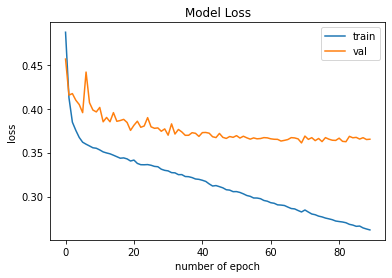

In [ ]:
plt.plot(history.history['loss'])              # Plotting the train and validation loss accross epochs to analyze performance change
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('../saved models/model_4.h5')

In [ ]:
model = tf.keras.models.load_model('../saved models/M_0.003_0.03_0.2658_0.3603.h5')  # Loading previously saved model

In [ ]:
model.evaluate(X_train,y_train)
model.evaluate(X_test,y_test)

101/101 [==============================] - 2s 10ms/step - loss: 0.3741


0.3740859925746918

In [ ]:
train_embeddings = model.predict(X_train)
np.save('../Embeddings/train_embeddings',train_embeddings)
np.save('../Embeddings/train_labels',y_train)

## Testing the model on AMI datacorpus 

We take 3 audio files: IB4011, IS1000c, TS3010c, calculate DER, and average the errors.



In [ ]:
def load_test_file(x_loc, y_loc, time_stamp_loc):
    X_test_us = np.load(x_loc) # mfcc features of dimension 20
    y_test_us = np.load(y_loc) # true speaker labels of those feature vector
    time_stamp_us = np.load(time_stamp_loc) # true speaker labels of those feature vector
    return (X_test_us, y_test_us, time_stamp_us)

In [ ]:
def plot_scatter_embedding(embedding_2d, y_label, graph_title):   # For plotting 2D graph of embeddings
    a=[]
    b=[]
    colors = ['black','red','green','blue','pink','brown']
    color_list = []
    for i in range(embedding_2d.shape[0]):
      a.append(embedding_2d[i][0])
      color_list.append(colors[y_label[i]])
    for i in range(embedding_2d.shape[0]):
      b.append(embedding_2d[i][1])
    plt.scatter(a,b,color = color_list)
    plt.title(graph_title)
    plt.show()


def make_spectral_clusters(test_d_vector_embedding_us):          # Returns predictd values from spectral clustering of the embeddings

    clusterer = SpectralClusterer(
        min_clusters=4,
        max_clusters=6,
        p_percentile=0.90,
        gaussian_blur_sigma=0.0)
    y_test_pred_spectral_us = clusterer.predict(test_d_vector_embedding_us)
    return y_test_pred_spectral_us

In [ ]:
def resegment(y_test_pred_spectral_us):             # Resegmentation of the predicted values for better accuracy
    i=2
    y1=[]
    y1.append(y_test_pred_spectral_us[0])
    y1.append(y_test_pred_spectral_us[1])
    for label_ in y_test_pred_spectral_us:
      if(i>=len(y_test_pred_spectral_us)-3):
        break
      if y_test_pred_spectral_us[i-2]==y_test_pred_spectral_us[i-1] and y_test_pred_spectral_us[i-1]==y_test_pred_spectral_us[i+1] and y_test_pred_spectral_us[i+1]==y_test_pred_spectral_us[i+2]:
        y1.append(y_test_pred_spectral_us[i-1])   # Changing the sandwitched value for reasonable prediction
      else:
        y1.append(y_test_pred_spectral_us[i])
      i=i+1

    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-3])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-2])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-1])
    return y1

In [ ]:
def der_calculation(reference, hypothesis):               # Calculating Diarization Error Rate
  from pyannote.metrics.diarization import DiarizationErrorRate
  diarizationErrorRate = DiarizationErrorRate()
  print("DER = {0:.3f}".format(diarizationErrorRate(reference, hypothesis, uem=Segment(0, 600))))
  print(diarizationErrorRate.optimal_mapping(reference, hypothesis))
  print(diarizationErrorRate(reference, hypothesis, detailed=True, uem=Segment(0, 600)))

def pyannote_graph(speaker_dictionary, time_stamp, y_label):
    reference = Annotation()
    speaker_dict_true= speaker_dictionary
    for i in range(time_stamp.shape[0]):
      reference[Segment(time_stamp[i][0], time_stamp[i][1])]= speaker_dict_true[ y_label[i]]
    return reference


In [ ]:
def predictions(test_list):
  for test_data_us in test_list:
    print("processing files of: ", test_data_us)
    x_loc='./mel_save_test_'+test_data_us+'.npy'
    y_loc='./mel_labels_test_'+test_data_us+'.npy'
    time_stamp_loc='./timestamps_save_'+test_data_us+'.npy'
    X_test_us, y_test_us, time_stamp_us=load_test_file(x_loc, y_loc, time_stamp_loc) 
    test_d_vector_embedding_us = model.predict(X_test_us)            # Getting the embeddings by passing features through the model
    print("Number of embeddings: ", test_d_vector_embedding_us.shape[0])
    test_2d_embedding_us = TSNE(n_components=2).fit_transform(test_d_vector_embedding_us)  # Applying dimentiality reduction to convert embedding into 2D for plotting

    y_test_pred_spectral=make_spectral_clusters(test_d_vector_embedding_us)   # Getting predicted speaker values using spectral clustering
    y_test_pred_GANMM = np.load('../predictions/GANMM_Cluster_'+test_data_us+'.npy')

    y1_spectral = resegment(y_test_pred_spectral)
    y1_GANMM = resegment(y_test_pred_GANMM)

    print("\nA) Diarization before resegmentation: ")

    test_2d_embedding_us = TSNE(n_components=2).fit_transform(test_d_vector_embedding_us)  # Applying dimentiality reduction to convert embedding into 2D for plotting
    plot_scatter_embedding(test_2d_embedding_us, y_test_us, "True Labels")
    plot_scatter_embedding(test_2d_embedding_us, y_test_pred_spectral, "Spectral Clustering")
    plot_scatter_embedding(test_2d_embedding_us, y_test_pred_GANMM, "GANMM Clustering")


    algos = ["Spectral Clustering","GANMM Clustering"]

    for i,y_pred in enumerate([y_test_pred_spectral,y_test_pred_GANMM]):
      print("\nDER using "+algos[i])
      speaker_dict_true={1:'A', 2:'B', 3:'C', 4:'D'}
      speaker_dict_hypo={0:'a', 1:'b', 2:'c', 3:'d'}
      reference= pyannote_graph(speaker_dict_true, time_stamp_us,  y_test_us)       # Getting the actual timeline of speakers
      hypothesis= pyannote_graph(speaker_dict_hypo, time_stamp_us,  y_pred)         # Getting the predicted timeline of speakers
      der = der_calculation(reference, hypothesis)                            # Calculating DER

    print("\nB) Diarization after resegmentation: ")

    plot_scatter_embedding(test_2d_embedding_us, y_test_us, "True Labels")
    plot_scatter_embedding(test_2d_embedding_us, y1_spectral, "Spectral Clustering")
    plot_scatter_embedding(test_2d_embedding_us, y1_GANMM, "GANMM Clustering")

    for i,y_pred in enumerate([y1_spectral,y1_GANMM]):
      print("\nDER using "+algos[i]+"\n")
      speaker_dict_true={1:'A', 2:'B', 3:'C', 4:'D'}
      speaker_dict_hypo={0:'a', 1:'b', 2:'c', 3:'d'}
      reference= pyannote_graph(speaker_dict_true, time_stamp_us,  y_test_us)        # Getting the actual timeline of speakers
      hypothesis= pyannote_graph(speaker_dict_hypo, time_stamp_us,  y_pred)          # Getting the predicted timeline of speakers
      der = der_calculation(reference, hypothesis)                            # Calculating DER


## Comparing Spectral Clustering and GANMM on Balanced Data

processing files of:  IS1000c
Number of embeddings:  1629

A) Diarization before resegmentation: 


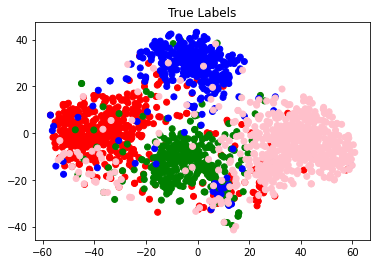

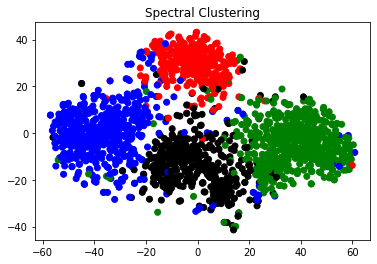

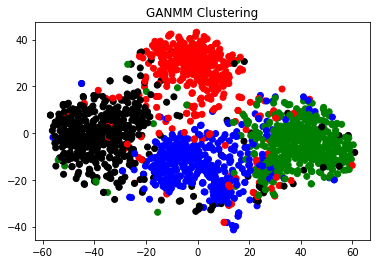


DER using Spectral Clustering
DER = 0.146
{'a': 'B', 'b': 'C', 'c': 'D', 'd': 'A'}
{'total': 357.94299999999987, 'correct': 305.7679999999999, 'confusion': 52.174999999999955, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.14576343160782576}

DER using GANMM Clustering
DER = 0.115
{'a': 'A', 'b': 'C', 'c': 'D', 'd': 'B'}
{'total': 357.94299999999987, 'correct': 316.7679999999999, 'confusion': 41.174999999999955, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.1150322816761327}

B) Diarization after resegmentation: 


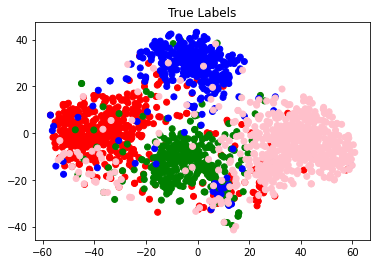

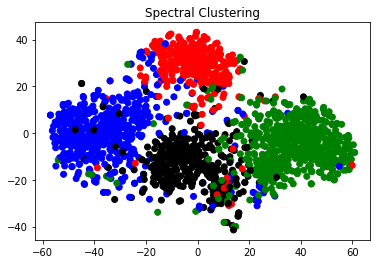

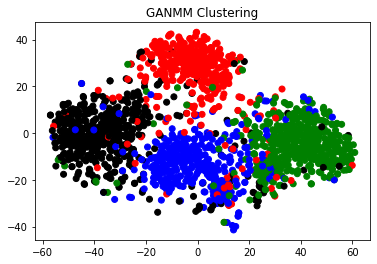


DER using Spectral Clustering

DER = 0.107
{'a': 'B', 'b': 'C', 'c': 'D', 'd': 'A'}
{'total': 357.94299999999987, 'correct': 319.56799999999987, 'confusion': 38.375, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.10720980714806551}

DER using GANMM Clustering

DER = 0.076
{'a': 'A', 'b': 'C', 'c': 'D', 'd': 'B'}
{'total': 357.94299999999987, 'correct': 330.56799999999987, 'confusion': 27.374999999999996, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.07647865721637245}


In [ ]:
test_list = ['IS1000c']
predictions(test_list)

## Comparing Spectral Clustering and GANMM on Imbalanced Data

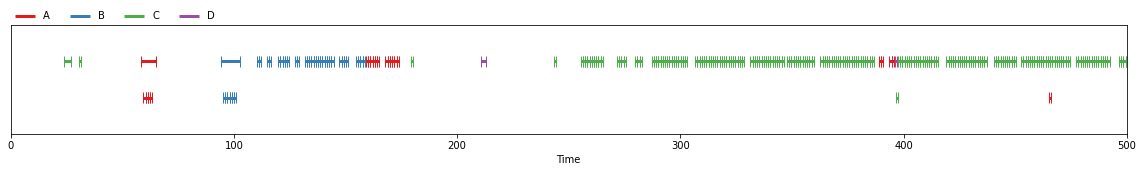

In [ ]:
reference

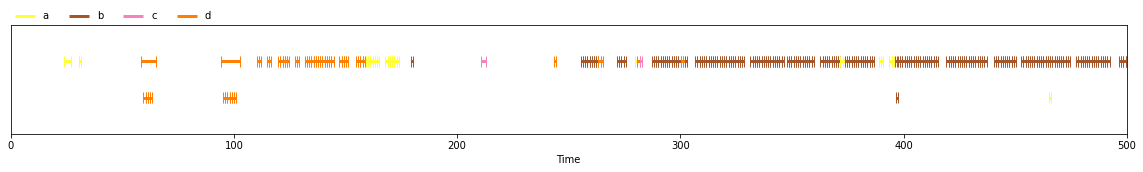

In [ ]:
hypothesis_1

processing files of:  custom_2
Number of embeddings:  500

A) Diarization before resegmentation: 


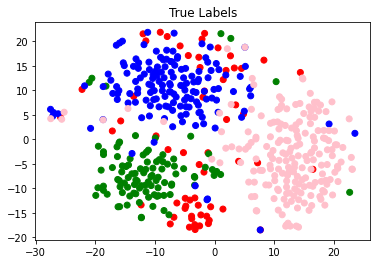

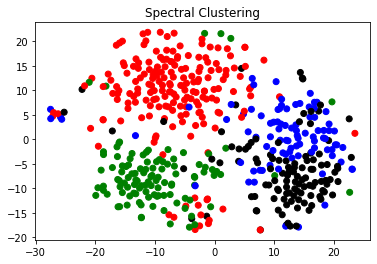

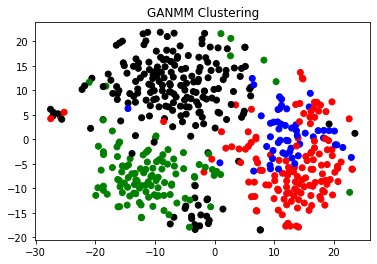


DER using Spectral Clustering
DER = 0.366
{'a': 'D', 'b': 'C', 'c': 'B', 'd': 'A'}
{'total': 500.0, 'correct': 317.0, 'confusion': 183.0, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.366}

DER using GANMM Clustering
DER = 0.250
{'a': 'C', 'b': 'D', 'c': 'B'}
{'total': 500.0, 'correct': 375.0, 'confusion': 125.0, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.25}

B) Diarization after resegmentation: 


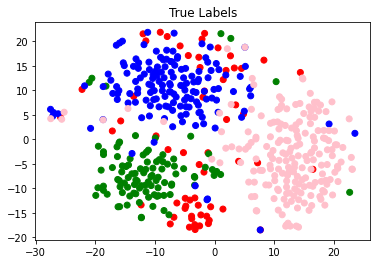

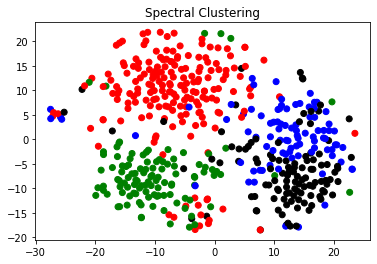

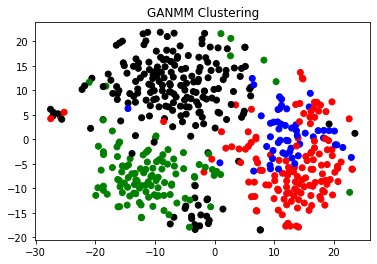


DER using Spectral Clustering

DER = 0.322
{'a': 'D', 'b': 'C', 'c': 'B', 'd': 'A'}
{'total': 500.0, 'correct': 339.0, 'confusion': 161.0, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.322}

DER using GANMM Clustering

DER = 0.246
{'a': 'C', 'b': 'D', 'c': 'B'}
{'total': 500.0, 'correct': 377.0, 'confusion': 123.0, 'false alarm': 0.0, 'missed detection': 0.0, 'diarization error rate': 0.246}


In [ ]:
test_list = ['custom_2']
predictions(test_list)

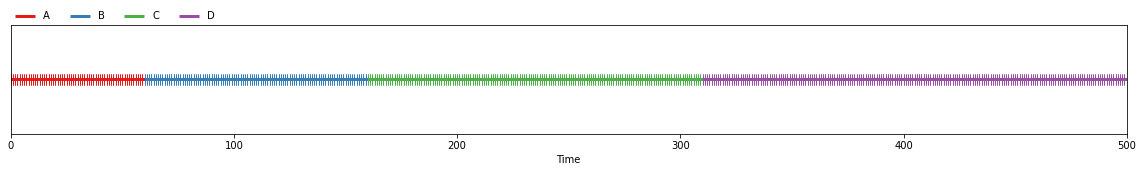

In [ ]:
reference

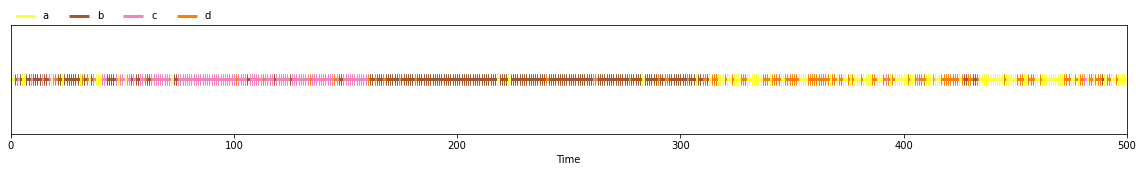

In [ ]:
hypothesis